# Finding similar words

Can we find an embedding space built on the movielens dataset to compare distance between titles?

Consider each person's viewing history as a series of titles.
Build a model to predict the next title watched based on the ones before it.
Or build a model to predict the middle title based on the ones either side.

Represent the titles as an embedding vector.
Build a dense layer on top of the embedding vector to predict the next title.

Follow an approach similar to Word2Vec.
Instead of treating each word as an entity or token, we use each title.
We treat the vocabulary as the set of titles.

1. Load the movielens dataset
2. Convert each movie title to an integer token
3. Create an embedding layer on the tokens
4. 

References:
* https://en.wikipedia.org/wiki/Word2vec

Start by importing stuff:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")

## Load data

Load the tiny Shakespeare dataset.

In [2]:
import torch
import requests
from torch.utils.data.dataset import Dataset
from pathlib import Path
import random


class ShakespeareDataCBOW(Dataset):
    def __init__(
        self,
        filepath: Path,
        window_size: int
    ):
        self.filepath = filepath
        self.window_size = window_size

        self._download_data()
        self.data = self._load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        
        # need to convert to tokens first
        
        data = []
        for i in range(len(sequence)):
            target_token = sequence[i]
            context = []
            for j in range(
                max(0, i - self.window_size),
                min(len(sequence), i + self.window_size + 1),
            ):
                if j != i:
                    context.append(sequence[j])
            data.append((context, target_token))
        return data

    def _download_data(self):
        "download to disk if not present already"

        self.filepath.parent.mkdir(parents=True, exist_ok=True)

        if not self.filepath.exists():
            print("downloading data")
            data_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
            with open(self.filepath, "wb") as f:
                f.write(requests.get(data_url).content)

    def _load_data(self) -> str:
        with open(self.filepath, "r") as f:
            data = f.read()
        data = data.splitlines()
        data = [sentence for sentence in data if sentence!='']
        return data


class CBOWDataset(Dataset):
    def __init__(self, sequences: list[int], window_size: int):
        self.sequences = sequences
        self.window_size = window_size

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        data = []
        for i in range(len(sequence)):
            target_word = sequence[i]
            context = []
            for j in range(
                max(0, i - self.window_size),
                min(len(sequence), i + self.window_size + 1),
            ):
                if j != i:
                    context.append(sequence[j])
            data.append((context, target_word))
        return data



filepath = Path().absolute() / "data" / "shakespeare.txt"
dataset = ShakespeareDataCBOW(
    filepath=filepath, window_size=1
)
dataset.__getitem__(0)


[(['i'], 'F'),
 (['F', 'r'], 'i'),
 (['i', 's'], 'r'),
 (['r', 't'], 's'),
 (['s', ' '], 't'),
 (['t', 'C'], ' '),
 ([' ', 'i'], 'C'),
 (['C', 't'], 'i'),
 (['i', 'i'], 't'),
 (['t', 'z'], 'i'),
 (['i', 'e'], 'z'),
 (['z', 'n'], 'e'),
 (['e', ':'], 'n'),
 (['n'], ':')]

Create tokens

1. Split by spaces - x
2. Lower case - x
3. Stem
4. Counter
5. Make vocab of top N words
6. Make word to token lookup table

In [3]:
from pathlib import Path

def _load_data(filepath) -> str:
    with open(filepath, "r") as f:
        data = f.read()
    data = data.splitlines()
    data = [sentence for sentence in data if sentence!='']
    return data

filepath = Path().absolute() / "data" / "shakespeare.txt"
data = _load_data(filepath=filepath)

In [4]:
import re

REG = re.compile("\w*")


def get_vocab(sentences: list[str]) -> dict[str, int]:

    words = " ".join(sentences).lower().split(" ")
    word_counts = {}
    for word in words:
        _word = REG.search(word)[0]
        word_counts[_word] = word_counts.get(_word, 0) + 1

    word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))
    # convert to tokens
    word_tokens = {key: idx for idx, (key, val) in enumerate(word_counts.items())}
    return word_counts, word_tokens


def sentence_to_token(sentence: str, vocab: dict[str, int]) -> list[int]:
    words = sentence.lower().split(" ")
    tokens = []
    for word in words:
        _word = REG.search(word)[0]
        tokens.append(vocab[_word])
    return tokens


def tokens_to_sentence(tokens: list[int], vocab: dict[str, int]) -> str:
    reverse_vocab = {val: key for key, val in vocab.items()}
    words = []
    for token in tokens:
        words.append(reverse_vocab[token])
    return " ".join(words)

word_counts, word_tokens = get_vocab(data)

In [5]:
sentence = data[16]
print(sentence)
tokens = sentence_to_token(sentence, word_tokens)
print(tokens)
words = tokens_to_sentence(tokens, word_tokens)
print(words)

No more talking on't; let it be done: away, away!
[35, 53, 2750, 46, 61, 15, 16, 158, 144, 144]
no more talking on let it be done away away


We will make a small subset of data for initial building and testing our models

In [6]:
data_small = data[:int(1e5)]
len(data_small)


32777

## Build model architecture

We will build the embedding using word2vec. There are two forms:

1. Continuous Bag of Words (CBOW):
In CBOW, the model predicts the current word (target word) based on the context words within a fixed window size.

1. Skip-gram:
In Skip-gram, the model predicts context words (surrounding words) given the current word (target word).

CBOW is generally faster to train compared to Skip-gram, especially when using small training datasets.
In our case the words are actually movies.

We will use CBOW for this test as hopefully its faster and more appropriate on a smallish training dataset.
Therefore we need to define a window of entities to train over. We will start with 3, so predict the current entity given the one before and the one after.


### Data preparation

We need to get sequenences of tokens. So we next create tokens from the movieIds as they do not start from 0 and are not sequential.
Then for each userId we convert the tokens in to a list.

In [7]:
def create_vocab():
    pass

def convert_to_tokens():
    pass



In [8]:
import tqdm


def convert_movies_to_tokens(ratings_df: pl.DataFrame):
    if "token" in ratings_df:
        ratings_df = ratings_df.drop("token")
    mapping = (
        ratings_df.group_by("movieId")
        .len()
        .sort("movieId")
        .with_row_index(name="token")
        .drop("len")
    )
    ratings_df = ratings_df.join(mapping, on="movieId")
    return ratings_df, mapping


def get_sequences_from_df(ratings_df: pl.DataFrame):
    sequences = []
    for _user_id in tqdm.tqdm(ratings_df["userId"].unique()):
        sequences.append(
            ratings_df.filter(pl.col("userId") == _user_id)["token"].to_list()
        )
    return sequences

In [9]:
ratings_small_df, token_mapping = convert_movies_to_tokens(ratings_small_df)
display(ratings_small_df.head(4))

sequences = get_sequences_from_df(ratings_small_df)
print(sequences[0][:10])

NameError: name 'ratings_small_df' is not defined

We can now create the CBOW dataset from the sequences.
We will use a small embedding size and a window of only 1.


We create a `collate_fn` to collect all the sequences and combine into tensors for training.

```
Sequence Data (e.g., Text, Time Series):
For sequence data, such as text or time series, the shape of a batch is often: (batch_size, sequence_length, input_dim).
batch_size is the number of sequences in the batch.
sequence_length is the length of each sequence.
input_dim represents the dimensionality of each element in the sequence (e.g., word embeddings for text).
```

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch


class CBOWDataset(Dataset):
    def __init__(self, sequences: list[int], window_size: int):
        self.sequences = sequences
        self.window_size = window_size

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        data = []
        for i in range(len(sequence)):
            target_word = sequence[i]
            context = []
            for j in range(
                max(0, i - self.window_size),
                min(len(sequence), i + self.window_size + 1),
            ):
                if j != i:
                    context.append(sequence[j])
            data.append((context, target_word))
        return data


def collate_fn(batch):
    # join all training examples into single tensor
    data = []
    targets = []
    for batch_item in batch:
        for _item in batch_item[1:-1]:
            data.append(_item[0])
            targets.append(_item[1])

    return torch.tensor(data), torch.tensor(targets).view(-1, 1)

In [ ]:
vocab_size = ratings_small_df["movieId"].unique().count()
window_size = 1

# Create dataset and dataloader
dataset = CBOWDataset(sequences, window_size)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

The training data is made up of pairs of tokens and the token from the middle. Here is a preview:

In [ ]:
dataset.__getitem__(0)[:5]

[([5], 46), ([46, 42], 5), ([5, 13], 42), ([42, 16], 13), ([13, 0], 16)]

Following the dataloader we get.

In [ ]:
batch = next(iter(dataloader))
batch

(tensor([[46, 42],
         [ 5, 13],
         [42, 16],
         ...,
         [29, 30],
         [26, 38],
         [30,  9]]),
 tensor([[ 5],
         [42],
         [13],
         ...,
         [26],
         [30],
         [38]]))

### Model architecture

The input to the model is a one-hot encoded vector representing the context words.
The hidden layer is a projection layer (embedding layer) that converts the one-hot encoded vectors into dense embedding vectors.
The output layer predicts the probability distribution of the target word given the context.
The model is trained to minimize the difference between the predicted probabilities and the actual word (softmax output).


The input to the model is a series of tokens representing the movies.
(These are converted to one-hot encoded vectors. Not needed?)
The tokens are converted into embedding vectors.

The embedding vectors of the context words are averaged to obtain a single context vector.
This context vector represents the overall context of the surrounding words.
The context vector is then passed through a linear transformation followed by a softmax activation function to produce a probability distribution over the entire vocabulary.

We then use a dense layer(s) to find the probability of each element in the vocabulary.
We compare against the true target word and use cross entropy loss to train the model weights, including the embedding layer.


With large vocabularies cross entropy loss can be expensive. There are approximations which are faster. We will stick with the full computation as we have a small vocab.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pytl


class CBOWModel(pytl.LightningModule):
    def __init__(
        self, vocab_size: int, embedding_dim: int, learning_rate: float = 1e-2
    ):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

        self.learning_rate = learning_rate
        self.train_log_error = []
        self.val_log_error = []

    def forward(self, context):
        embedded_context = self.embeddings(context)
        # sum over context to get single embedding vector
        sum_embedded_context = torch.sum(embedded_context, dim=1)
        output = self.linear(sum_embedded_context)
        return output

    def training_step(self, batch, batch_idx):
        context, target = batch
        context = torch.tensor(context).squeeze(1)
        target = torch.tensor(target).squeeze(1)
        output = self(context)
        loss = nn.CrossEntropyLoss()(output, target)

        self.train_log_error.append(loss.item())
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test with a single training example

We have 28 sequences in the training example and they return a value for each title in the vocabulary (50).

In [ ]:
embedding_dim = 20
model = CBOWModel(vocab_size, embedding_dim)
batch = next(iter(dataloader))
model(batch[0]).shape

torch.Size([1770, 50])

In [ ]:
# Initialize and train CBOW model
model = CBOWModel(vocab_size, embedding_dim)
trainer = pytl.Trainer(max_epochs=1)
trainer.fit(model, dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name       | Type      | Params
-----------------------------------------
0 | embeddings | Embedding | 1.0 K 
1 | linear     | Linear    | 1.1 K 
-----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/770 [00:00<?, ?it/s] 

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_14807/3033210348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(context).squeeze(1)
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_14807/3033210348.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target).squeeze(1)


Epoch 0:  46%|████▌     | 354/770 [00:16<00:19, 21.12it/s, v_num=16]

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_13627/3426034194.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


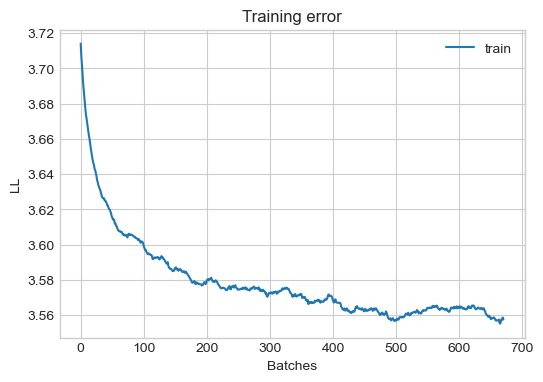

In [ ]:
import numpy as np


def moving_average(x, window_size):
    """Calculate the moving average of a list using numpy."""
    return np.convolve(x, np.ones(window_size) / window_size, mode="valid")


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(moving_average(model.train_log_error, 100), label="train")
ax.set_title(f"Training error")
ax.set_xlabel("Batches")
ax.set_ylabel("LL")
ax.legend()
fig.show()

In [ ]:
batch = next(iter(dataloader))
model(batch[0])

tensor([[ 0.1166, -1.3725,  0.0836,  ...,  2.5572,  0.0068,  1.3334],
        [ 1.4388,  0.8244,  0.1035,  ..., -2.7618, -1.5350, -1.8414],
        [-0.3982, -0.0392,  0.1584,  ...,  0.4545, -0.1839,  0.6076],
        ...,
        [ 0.1540,  0.3423, -0.2818,  ..., -0.5759, -0.4444, -2.2692],
        [ 0.0410,  0.4492,  0.1212,  ...,  0.9471, -0.5792,  0.4750],
        [ 0.3203,  1.1729,  0.1938,  ..., -1.3214, -1.2435, -1.9945]],
       grad_fn=<AddmmBackward0>)

## Find embedding vectors

In [ ]:
import torch
import torch.nn.functional as F


def calculate_cosine_similarity(embedding_matrix):
    normalized_embeddings = F.normalize(embedding_matrix, p=2, dim=1)
    return torch.matmul(normalized_embeddings, normalized_embeddings.t())


embedding_matrix = model.embeddings.weight
similarities = calculate_cosine_similarity(embedding_matrix.cpu()).detach().numpy()
similarities[np.triu_indices(similarities.shape[0], k=1)] = np.nan

Plot results

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_13627/3547380529.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


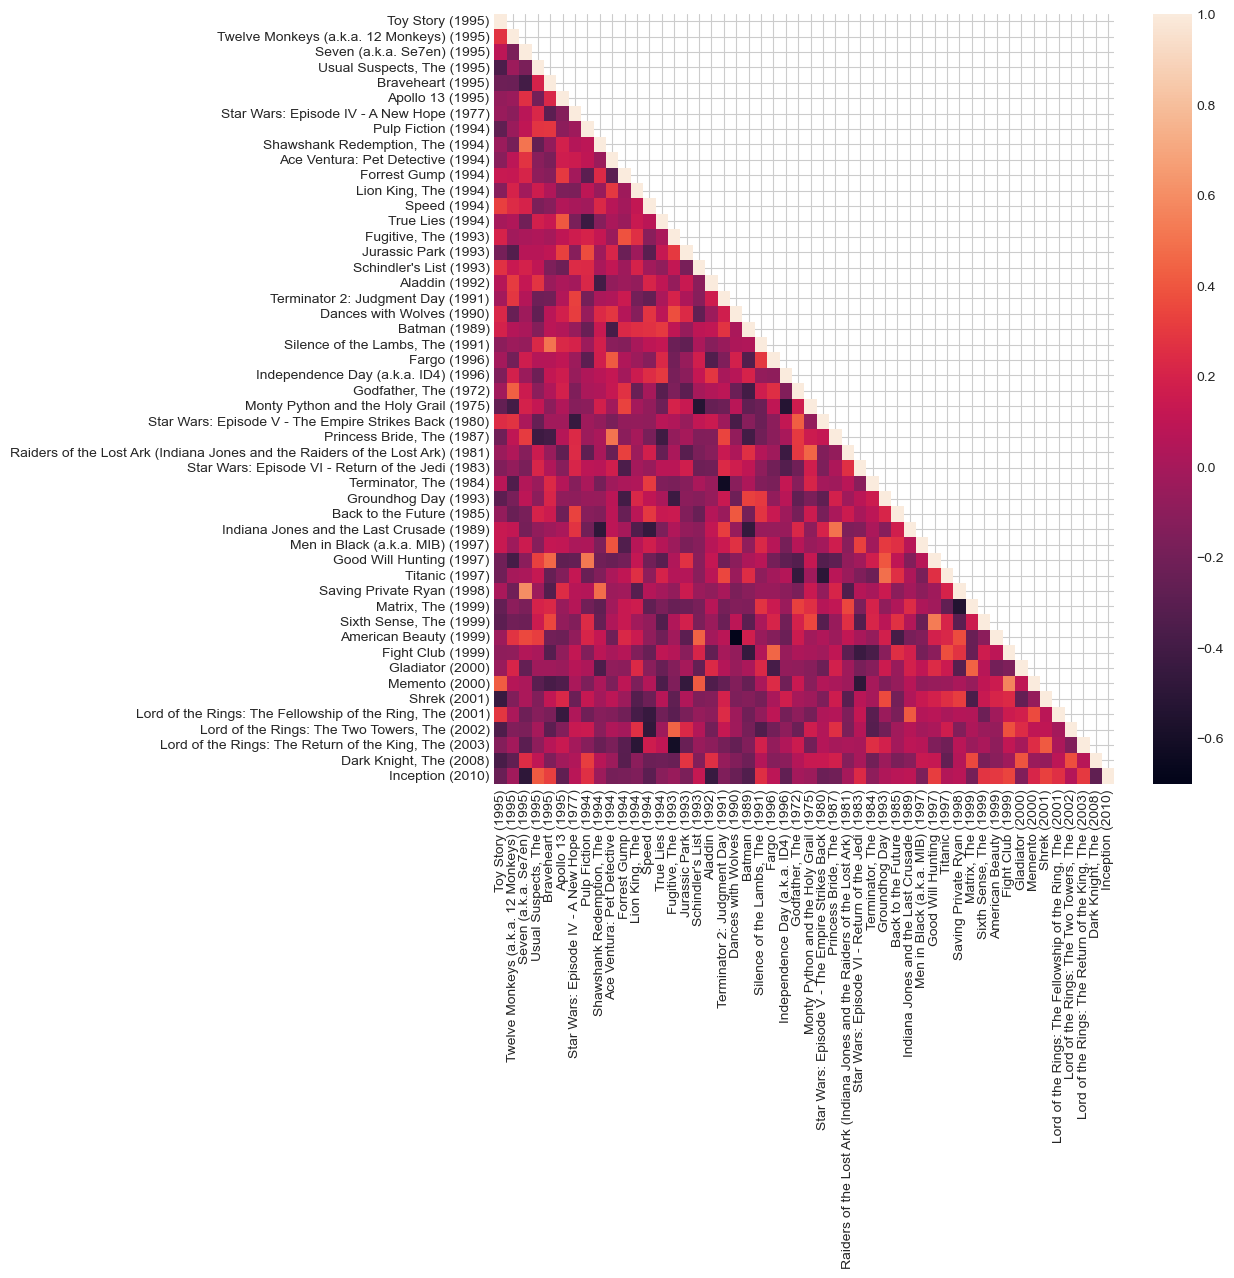

In [ ]:
labels = token_mapping.join(names_df, on="movieId").sort("token")["title"].to_list()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    data=similarities,
    ax=ax,
    xticklabels=labels,
    yticklabels=labels,
)
fig.show()

Strong correlations

In [ ]:
def top_n_indices(arr, n: int = 10):
    arr = np.abs(np.nan_to_num(arr, 0))
    np.fill_diagonal(arr, 0)
    sorted_indices = np.argsort(arr.flatten())
    # return sorted_indices
    top_n_indices = np.flip(sorted_indices[-n:])
    row_indices, col_indices = np.unravel_index(top_n_indices, arr.shape)

    return list(zip(row_indices, col_indices))


indices = top_n_indices(similarities)
print(similarities[indices[0][0], indices[0][1]])
print(labels[indices[0][0]], labels[indices[0][1]])
print(similarities[indices[1][0], indices[1][1]])
print(labels[indices[1][0]], labels[indices[1][1]])
print(similarities[indices[2][0], indices[2][1]])
print(labels[indices[2][0]], labels[indices[1][1]])
indices

-0.70105886
American Beauty (1999) Dances with Wolves (1990)
-0.6309868
Terminator, The (1984) Terminator 2: Judgment Day (1991)
-0.6087099
Lord of the Rings: The Return of the King, The (2003) Terminator 2: Judgment Day (1991)


[(40, 19),
 (30, 18),
 (47, 14),
 (37, 2),
 (43, 41),
 (38, 37),
 (25, 23),
 (25, 16),
 (39, 35),
 (35, 7)]

The model trains quickly but doesn't give much useful results.
Let's now try with a larger dataset.

# TODO
* Larger dataset
* Using

### Ratings based
The above Word2Vec approach will be assuming that people watched films that are similar in succession.

We have explicit ratings in the dataset we can use for a better indication.
We are assuming that people rate highly movies that are similar.

We also have genre information, how can we exploit this?

### Text dataset
Can we confirm the above approach with text data.

## Larger dataset

In [ ]:
top_movie_ids = (
    ratings_df.group_by("movieId")
    .count()
    .sort("count", descending=True)
    .head(200)[["movieId"]]
)
ratings_med_df = ratings_df.join(top_movie_ids, on="movieId", how="inner")

user_id_counts = (
    ratings_med_df.group_by("userId")
    .count()
    .filter(pl.col("count") >= 20)[["userId"]]
)
ratings_med_df = ratings_med_df.join(user_id_counts, on="userId", how="inner")
ratings_med_df.shape

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_14579/3647007902.py:3: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_14579/3647007902.py:11: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


(5954554, 4)

In [ ]:
ratings_med_df, token_mapping = convert_movies_to_tokens(ratings_med_df)
display(ratings_med_df.head(4))

sequences = get_sequences_from_df(ratings_med_df)
print(sequences[0][:10])

vocab_size = ratings_med_df["movieId"].unique().count()
window_size = 1

# Create dataset and dataloader
dataset = CBOWDataset(sequences, window_size)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

embedding_dim = 20
model = CBOWModel(vocab_size, embedding_dim)
trainer = pytl.Trainer(max_epochs=1)
trainer.fit(model, dataloader)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(moving_average(model.train_log_error, 100), label="train")
ax.set_title(f"Training error")
ax.set_xlabel("Batches")
ax.set_ylabel("LL")
ax.legend()
fig.show()

embedding_matrix = model.embeddings.weight
similarities = calculate_cosine_similarity(embedding_matrix.cpu()).detach().numpy()
similarities[np.triu_indices(similarities.shape[0], k=1)] = np.nan

labels = token_mapping.join(names_df, on="movieId").sort("token")["title"].to_list()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    data=similarities,
    ax=ax,
    xticklabels=labels,
    yticklabels=labels,
)
fig.show()

userId,movieId,rating,timestamp,token
i64,i64,f64,i64,u32
1,5952,4.0,1147868053,5840
1,2012,2.5,1147868068,1923
1,2011,2.5,1147868079,1922
1,1653,4.0,1147868097,1591


100%|██████████| 162541/162541 [14:16<00:00, 189.87it/s]


[5840, 1923, 1922, 1591, 1217, 6416, 6258, 3352, 1061, 878]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type      | Params
-----------------------------------------
0 | embeddings | Embedding | 1.2 M 
1 | linear     | Linear    | 1.2 M 
-----------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.684     Total estimated model params size (MB)
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/2540 [00:00<?, ?it/s] 

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_13627/3033210348.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(context).squeeze(1)
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_13627/3033210348.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target).squeeze(1)


Epoch 0:   0%|          | 1/2540 [00:10<7:14:37, 10.27s/it, v_num=15]

RuntimeError: MPS backend out of memory (MPS allocated: 7.13 GB, other allocations: 1.86 GB, max allowed: 9.07 GB). Tried to allocate 1.73 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
raise NotImplementedError

NotImplementedError: 